Header for notebooks -- customize as required.

In [8]:
# notebook configuration
COLAB = False # will trigger manual installation of packages
USE_GPU = True 

In [9]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random

In [10]:
%matplotlib inline
%config Completer.use_jedi = False
os.environ['WANDB_NOTEBOOK_NAME'] = f"nb_{datetime.now().strftime('%Y%m%d')}.ipynb"

Now, non-stdlib imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# general ML tooling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import log_loss, roc_auc_score
import wandb
from wandb.xgboost import wandb_callback
from wandb.lightgbm import wandb_callback
from sklearn.impute import SimpleImputer #, KNNImputer

import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.preprocessing import RobustScaler #StandardScaler #, MinMaxScaler, MaxAbsScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import SelectKBest, f_regression
from joblib import dump, load
# feature engineering tools
# from sklearn.feature_selection import mutual_info_regression
# import featuretools as ft

from BorutaShap import BorutaShap

In [12]:
from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep#, SAINT, TabTransformer, TabNet, TabFastFormer, TabResnet
from pytorch_widedeep.metrics import Accuracy
from torchmetrics import AUROC
import torch
from torch.optim import Adam, AdamW, Adagrad, SGD, RMSprop, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR, OneCycleLR, StepLR, CosineAnnealingLR
from pytorch_widedeep.callbacks import EarlyStopping, LRHistory, ModelCheckpoint

In [13]:
# import category_encoders as ce

Now, datapath setup

In [14]:
if COLAB:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
    datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/nov2021/')
    
else:
    # if on local machine
#     datapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/')  
    root = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/nov2021/')
    datapath = root/'datasets'
    # edapath = root/'EDA'
    # modelpath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/models/')
    predpath = root/'preds'
    subpath = root/'submissions'
    
    for pth in [datapath, predpath, subpath]:
        pth.mkdir(exist_ok=True)
    


## Helpers

In [15]:
SEED = 42

# Function to seed everything
def seed_everything(seed, reproducible=True):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # torch.manual_seed(seed) # set torch CPU seed
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed_all(seed) # set torch GPU(s) seed(s)
    # if reproducible and torch.backends.cudnn.is_available():
    #     torch.backends.cudnn.deterministic = True
    #     torch.backends.cudnn.benchmark = False

seed_everything(seed=SEED)

In [16]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

## Metadata

In [17]:
# dataset_params will initially include either trivial class instances or loaded, precomputed artifacts
dataset_params = {
    # 'train_source': str(datapath/'X-RobustScaled-pca_mle-umap_embedding_20211107-n_comp10-n_neighbors15-rs42.joblib'),
    'train_source': str(datapath/'X_orig.feather'),
    'target_source': str(datapath/'y_orig.joblib'),
    # 'test_source': str(datapath/'X_test-RobustScaled-pca_mle-umap_embedding_20211107-n_comp10-n_neighbors15-rs42.joblib'),
    'test_source': str(datapath/'X_test_orig-no_scaling.feather'),
    # 'scaler': str(RobustScaler()),
    # 'pca': str(load(datapath/'pca_mle-RobustScaled_orig_trainset.joblib')),
    # 'umap': str(load(datapath/'umap_reducer-20211107-n_comp10-n_neighbors15-rs42-pca_mle-RobustScaled_orig_trainset.joblib')),
}   

# referring back to the already-entered attributes, specify how the pipeline was sequenced
# dataset_params['preprocessing_pipeline'] = str([dataset_params['scaler'], dataset_params['pca'], dataset_params['umap']]) # ACTUALLY this is unwieldy
# dataset_params['preprocessing_pipeline'] = '[scaler, pca, umap]' # more fragile, but also more readable

# now, load the datasets and generate more metadata from them
# X = load(dataset_params['train_source'])
X = pd.read_feather(dataset_params['train_source'])
y = load(dataset_params['target_source'])
# X_test = load(dataset_params['test_source'])
X_test = pd.read_feather(dataset_params['test_source'])

dataset_params['feature_count'] = X.shape[1]
dataset_params['instance_count'] = X.shape[0]
    

In [18]:
# meta-config for preprocessing and cross-validation, but NOT for model parameters
exmodel_config = {
#     "feature_selector": SelectKBest,
#     "k_best": 80,
#     "feature_selection_scoring": f_regression,
#     'random_state': SEED,
#     'feature_generation': ['NaN_counts', 'SummaryStats', 'NaN_OneHots'],
#     'subsample': 1,
    'cross_val_strategy': KFold, # None for holdout, or the relevant sklearn class
    'kfolds': 5, # if 1, that means just doing holdout
    'test_size': 0.2,
    **dataset_params
#     'features_created': False,
#     'feature_creator': None,
}

In [19]:
from doubtlab.ensemble import DoubtEnsemble
from doubtlab.reason import CleanlabReason, AbsoluteDifferenceReason, DisagreeReason, LongConfidenceReason, MarginConfidenceReason, OutlierReason, ProbaReason, RelativeDifferenceReason, WrongPredictionReason 

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [21]:
model = XGBClassifier(booster='gbtree',
                      tree_method='gpu_hist',
                      random_state=42,
                      # n_jobs=-1, 
                      verbosity=1, 
                      objective='binary:logistic',
                      # **params
                     )

model.fit(X,y)

# y_valid_preds = model.predict_proba(X_valid)[:,1]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:49:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=1)

In [24]:
reasons = {
    "cleanlab": CleanlabReason(model),
    # AbsoluteDifferenceReason, 
    # DisagreeReason, 
    "overconfident": LongConfidenceReason(model), 
    "outlier": OutlierReason(model), 
    "shaky": ProbaReason(model, max_proba=0.4), 
    # RelativeDifferenceReason, 
    "wrong": WrongPredictionReason(model)
}

doubt = DoubtEnsemble(**reasons)

indices = doubt.get_indices(X,y)

In [25]:
len(indices)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


528776

In [26]:
type(indices)

numpy.ndarray

In [28]:
predicates = doubt.get_predicates(X,y)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [29]:
predicates.head()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,predicate_cleanlab,predicate_overconfident,predicate_outlier,predicate_shaky,predicate_wrong
593165,0,0.974799,0.0,0.0,1.0
148703,0,0.966283,0.0,0.0,1.0
277717,0,0.961299,0.0,0.0,1.0
340086,0,0.958784,0.0,0.0,1.0
197636,0,0.958125,0.0,0.0,1.0


In [32]:
wrongs = predicates.loc[(predicates['predicate_wrong'] == 1)]# and (predicates['predicate_overconfident'] > 0.8)]

In [33]:
wrongs.shape

(162188, 5)

In [35]:
wrongs.iloc[:50, :]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,predicate_cleanlab,predicate_overconfident,predicate_outlier,predicate_shaky,predicate_wrong
593165,0,0.974799,0.0,0.0,1.0
148703,0,0.966283,0.0,0.0,1.0
277717,0,0.961299,0.0,0.0,1.0
340086,0,0.958784,0.0,0.0,1.0
197636,0,0.958125,0.0,0.0,1.0
591668,0,0.957591,0.0,0.0,1.0
364507,0,0.957443,0.0,0.0,1.0
183911,0,0.955212,0.0,0.0,1.0
54498,0,0.954677,0.0,0.0,1.0
400464,0,0.954605,0.0,0.0,1.0


In [36]:
confidently_wrongs = wrongs.loc[wrongs['predicate_overconfident'] > 0.85]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [37]:
confidently_wrongs.shape

(5688, 5)

In [38]:
confidently_wrongs

,predicate_cleanlab,predicate_overconfident,predicate_outlier,predicate_shaky,predicate_wrong
593165,0,0.974799,0.0,0.0,1.0
148703,0,0.966283,0.0,0.0,1.0
277717,0,0.961299,0.0,0.0,1.0
340086,0,0.958784,0.0,0.0,1.0
197636,0,0.958125,0.0,0.0,1.0
...,...,...,...,...,...
234092,0,0.850026,0.0,0.0,1.0
198248,0,0.850021,0.0,0.0,1.0
471551,0,0.850020,0.0,0.0,1.0
43990,0,0.850015,0.0,0.0,1.0


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([[<AxesSubplot:title={'center':'predicate_cleanlab'}>,
        <AxesSubplot:title={'center':'predicate_overconfident'}>],
       [<AxesSubplot:title={'center':'predicate_outlier'}>,
        <AxesSubplot:title={'center':'predicate_shaky'}>],
       [<AxesSubplot:title={'center':'predicate_wrong'}>, <AxesSubplot:>]],
      dtype=object)

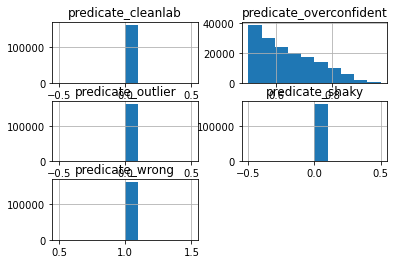

In [39]:
wrongs.hist()

array([[<AxesSubplot:title={'center':'predicate_cleanlab'}>,
        <AxesSubplot:title={'center':'predicate_overconfident'}>],
       [<AxesSubplot:title={'center':'predicate_outlier'}>,
        <AxesSubplot:title={'center':'predicate_shaky'}>],
       [<AxesSubplot:title={'center':'predicate_wrong'}>, <AxesSubplot:>]],
      dtype=object)

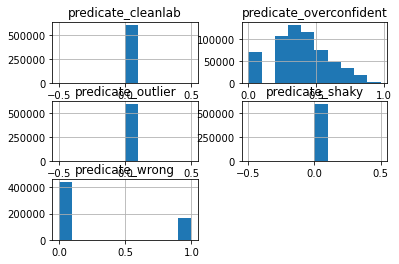

In [40]:
predicates.hist()

In [42]:
np.where(predicates['predicate_cleanlab'] == 1)

(array([], dtype=int64),)

In [43]:
np.where(predicates['predicate_outlier'] == 1)

(array([], dtype=int64),)

In [46]:
overconfidents = predicates['predicate_overconfident']

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


<AxesSubplot:>

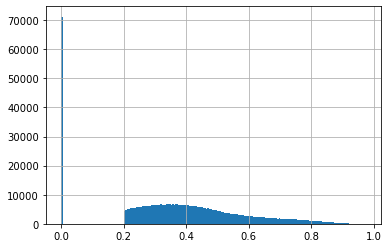

In [47]:
overconfidents.hist(bins=200)

In [48]:
predicates.shape

(600000, 5)

In [55]:
overconfidents_actual = overconfidents > 0

In [56]:
overconfidents_actual.shape

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(600000,)

In [57]:
overconfidents.min()

0.0

In [59]:
overconfidents.max()

0.974799394607544

In [63]:
overconfidents_actual = overconfidents[overconfidents > 0]

In [64]:
overconfidents_actual.shape

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(528776,)

In [68]:
overconfidents_40 = overconfidents[overconfidents > 0.4]
overconfidents_70 = overconfidents[overconfidents > 0.7]

In [66]:
overconfidents_70.shape

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(45848,)

In [69]:
overconfidents_40.shape

(276275,)

<AxesSubplot:>

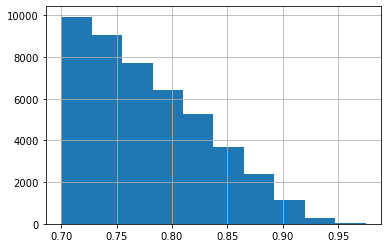

In [70]:
overconfidents_70.hist()
